# Uncertainty Quantification: A Practical Guide

**Learning Objectives:**
- Understand what uncertainty quantification is and why it matters
- Learn the difference between Bayesian credible intervals and Frequentist confidence intervals
- Apply uncertainty quantification to business projections
- Visualize uncertainty bounds in predictions

---


## Part 1: What is Uncertainty Quantification?

**Uncertainty Quantification (UQ)** is the science of characterizing, quantifying, and reducing uncertainty in computational and real-world applications. It involves:

1. **Identifying sources of uncertainty**: Model uncertainty, parameter uncertainty, data uncertainty, and aleatoric (inherent randomness) vs. epistemic (lack of knowledge) uncertainty
2. **Quantifying uncertainty**: Using statistical methods to measure and express uncertainty
3. **Propagating uncertainty**: Understanding how uncertainty flows through models and predictions
4. **Visualizing uncertainty**: Communicating uncertainty effectively through intervals, distributions, and bounds

### Key Concepts

- **Point estimates** give single values (e.g., "revenue will be $1M")
- **Uncertainty intervals** provide ranges (e.g., "revenue will be between $800K and $1.2M with 95% confidence")
- **Probability distributions** show the full range of possible outcomes and their likelihoods


## Part 2: Why Uncertainty Quantification Matters in Business Settings

When making projections that inform business decisions, uncertainty quantification is crucial for several reasons:

### 1. **Risk Management**
- **Without UQ**: "Sales will grow 10% next quarter" → Single point estimate
- **With UQ**: "Sales will grow 10% ± 3% (95% confidence)" → Decision-makers understand the risk
- Enables better risk assessment and contingency planning

### 2. **Resource Allocation**
- **Without UQ**: Allocate resources based on a single projection
- **With UQ**: Understand worst-case and best-case scenarios to allocate resources more efficiently
- Helps avoid over-investment or under-investment

### 3. **Stakeholder Communication**
- **Without UQ**: Stakeholders may have unrealistic expectations
- **With UQ**: Transparent communication about what we know and don't know
- Builds trust and sets appropriate expectations

### 4. **Decision Making Under Uncertainty**
- **Without UQ**: Decisions based on point estimates can lead to poor outcomes
- **With UQ**: Decisions can incorporate uncertainty, leading to more robust strategies
- Enables scenario planning and stress testing

### 5. **Regulatory Compliance**
- Many industries require uncertainty reporting (finance, healthcare, environmental)
- Demonstrates due diligence and scientific rigor
- Meets compliance requirements

### 6. **Model Validation**
- Uncertainty bounds help validate model performance
- If actual outcomes fall outside uncertainty intervals, it signals model issues
- Enables continuous model improvement

### Real-World Example
Imagine forecasting quarterly revenue:
- **Point estimate**: $5M
- **With uncertainty**: $5M ± $500K (90% interval)
- **Business impact**: 
  - If actual is $4.5M (within bounds): Expected variation, no action needed
  - If actual is $3.5M (outside bounds): Model may need revision or external factors changed


## Part 3: Setup and Data Generation

Let's start by importing necessary libraries and generating sample data that represents a business metric over time (e.g., revenue, sales, user count).


In [34]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Generate sample data: value vs year
# Simulating business growth with some noise
years = np.array([2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024])
# True underlying trend: exponential growth with some noise
true_trend = 100 * np.exp(0.15 * (years - 2015))  # Exponential growth
noise = np.random.normal(0, 15, size=len(years))  # Random noise
values = true_trend + noise

# Ensure values are positive (business metrics are typically positive)
values = np.maximum(values, 50)

# Create DataFrame
data = pd.DataFrame({'year': years, 'value': values})

# Select only the last 5 years for model fitting
years_fit = years[-5:]  # Last 5 years: 2020-2024
values_fit = values[-5:]  # Corresponding values

print("Full Dataset:")
print(data)
print(f"\nData for Model Fitting (Last 5 Years):")
fit_data = pd.DataFrame({'year': years_fit, 'value': values_fit})
print(fit_data)
print(f"\nFull data shape: {data.shape}")
print(f"Fitting data shape: {fit_data.shape}")
print(f"Value range (full): ${values.min():.2f}K - ${values.max():.2f}K")
print(f"Value range (fitting): ${values_fit.min():.2f}K - ${values_fit.max():.2f}K")


Full Dataset:
   year       value
0  2015  107.450712
1  2016  114.109460
2  2017  144.701209
3  2018  179.676666
4  2019  178.699579
5  2020  208.187947
6  2021  269.648503
7  2022  297.276633
8  2023  324.969576
9  2024  393.880954

Data for Model Fitting (Last 5 Years):
   year       value
0  2020  208.187947
1  2021  269.648503
2  2022  297.276633
3  2023  324.969576
4  2024  393.880954

Full data shape: (10, 2)
Fitting data shape: (5, 2)
Value range (full): $107.45K - $393.88K
Value range (fitting): $208.19K - $393.88K


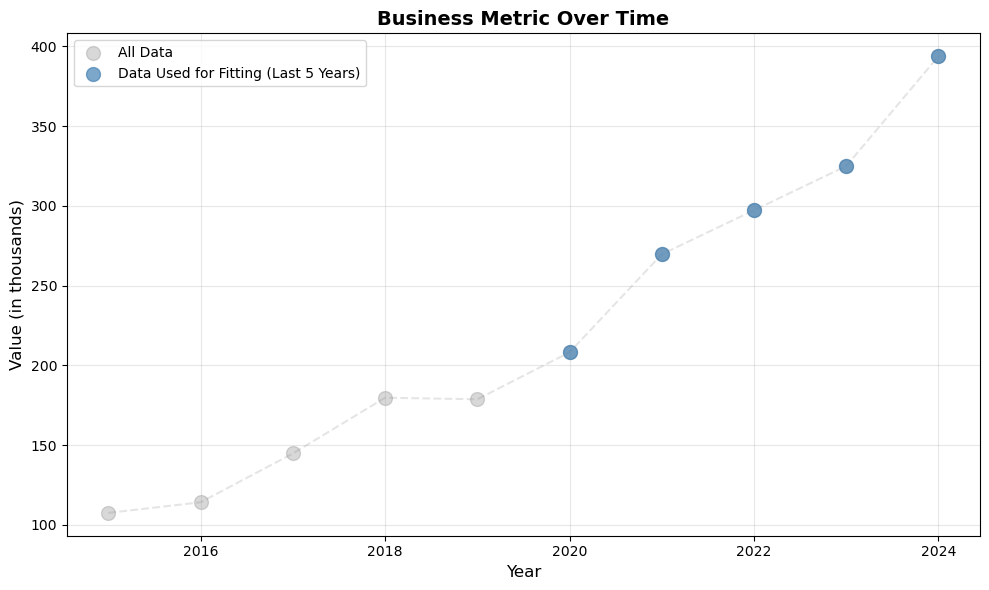

In [35]:
# Visualize the data
plt.figure(figsize=(10, 6))
plt.scatter(years, values, s=100, alpha=0.3, color='gray', label='All Data')
plt.scatter(years_fit, values_fit, s=100, alpha=0.7, color='steelblue', 
           label='Data Used for Fitting (Last 5 Years)', zorder=5)
plt.plot(years, values, '--', alpha=0.2, color='gray')
plt.xlabel('Year', fontsize=12)
plt.ylabel('Value (in thousands)', fontsize=12)
plt.title('Business Metric Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


## Part 4: Frequentist Approach - Confidence Intervals

### Understanding Confidence Intervals

A **confidence interval** is a Frequentist concept that describes the uncertainty in parameter estimates. 

**Key interpretation**: If we were to repeat the experiment many times, 95% of the confidence intervals we construct would contain the true parameter value.

**Important**: The confidence interval is about the **procedure**, not about the specific interval. We cannot say "there's a 95% probability that the true value is in this interval" - that would be a Bayesian statement.

### Example: Linear Regression with Confidence Intervals

We'll fit a linear regression model and compute confidence intervals for predictions.


In [36]:
# Fit linear regression model using only last 5 years
X = years_fit.reshape(-1, 1)
y = values_fit

# Fit the model
model = LinearRegression()
model.fit(X, y)

# Predictions for observed years (used for fitting)
y_pred = model.predict(X)

# Future years for extrapolation
future_years = np.array([2025, 2026, 2027, 2028, 2029])
X_future = future_years.reshape(-1, 1)
y_future_pred = model.predict(X_future)

print("Linear Regression Model (Fitted on Last 5 Years):")
print(f"Training years: {years_fit[0]}-{years_fit[-1]}")
print(f"Slope: {model.coef_[0]:.2f}")
print(f"Intercept: {model.intercept_:.2f}")
print(f"\nPredicted values for future years:")
for year, pred in zip(future_years, y_future_pred):
    print(f"  {year}: ${pred:.2f}K")


Linear Regression Model (Fitted on Last 5 Years):
Training years: 2020-2024
Slope: 42.67
Intercept: -85981.38

Predicted values for future years:
  2025: $426.80K
  2026: $469.48K
  2027: $512.15K
  2028: $554.82K
  2029: $597.49K


In [37]:
# Calculate confidence intervals using Frequentist approach
# This uses the standard error of the regression

# Combine fitting years and future years for plotting
all_years = np.concatenate([years_fit, future_years])
X_all = all_years.reshape(-1, 1)
y_all_pred = model.predict(X_all)

# Calculate residuals (using only fitting data)
residuals = y - y_pred
mse = np.mean(residuals**2)  # Mean squared error
n = len(years_fit)  # Number of data points used for fitting
p = 2  # Number of parameters (slope + intercept)

# Standard error for predictions
X_mean = np.mean(years_fit)
Sxx = np.sum((years_fit - X_mean)**2)

# For each prediction point
se_pred = np.sqrt(mse * (1 + 1/n + (all_years - X_mean)**2 / Sxx))

# t-statistic for 95% confidence interval (two-tailed)
t_critical = stats.t.ppf(0.975, df=n-p)

# Confidence intervals
ci_lower = y_all_pred - t_critical * se_pred
ci_upper = y_all_pred + t_critical * se_pred

print(f"95% Confidence Intervals:")
print(f"t-critical value: {t_critical:.3f}")
print(f"\nFuture predictions with 95% CI:")
for i, year in enumerate(future_years):
    idx = len(years_fit) + i  # Index in all_years array (starts with years_fit, then future_years)
    print(f"  {year}: ${y_all_pred[idx]:.2f}K [{ci_lower[idx]:.2f}, {ci_upper[idx]:.2f}]")


95% Confidence Intervals:
t-critical value: 3.182

Future predictions with 95% CI:
  2025: $426.80K [377.13, 476.48]
  2026: $469.48K [412.12, 526.83]
  2027: $512.15K [446.21, 578.08]
  2028: $554.82K [479.72, 629.91]
  2029: $597.49K [512.83, 682.14]


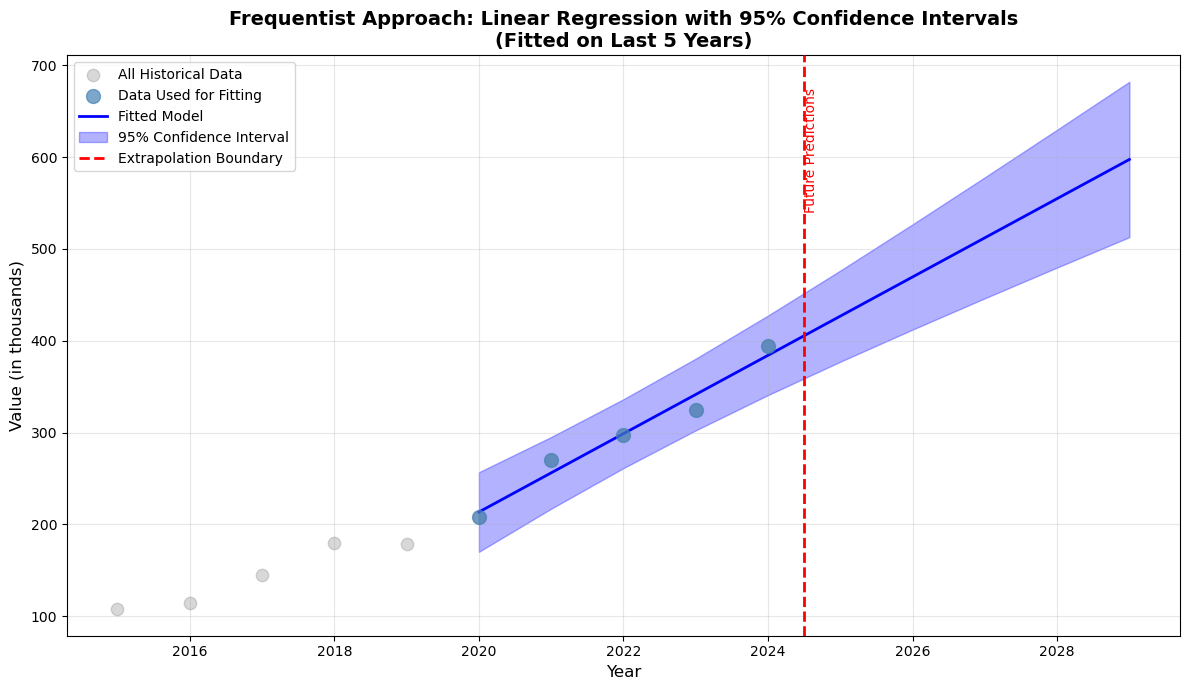


Interpretation:
The confidence interval shows the uncertainty in the regression line.
If we repeated this experiment many times, 95% of such intervals would
contain the true regression line. Note: The interval widens as we
extrapolate further into the future (increasing uncertainty).


In [38]:
# Visualize Frequentist confidence intervals
plt.figure(figsize=(12, 7))

# Plot all observed data (light gray)
plt.scatter(years, values, s=80, alpha=0.3, color='gray', 
           label='All Historical Data', zorder=2)

# Plot data used for fitting (highlighted)
plt.scatter(years_fit, values_fit, s=100, alpha=0.7, color='steelblue', 
           label='Data Used for Fitting', zorder=5)

# Plot fitted line
plt.plot(all_years, y_all_pred, 'b-', linewidth=2, label='Fitted Model', zorder=3)

# Plot confidence intervals
plt.fill_between(all_years, ci_lower, ci_upper, alpha=0.3, color='blue', 
                label='95% Confidence Interval', zorder=1)

# Add vertical line to separate observed from future
plt.axvline(x=2024.5, color='red', linestyle='--', linewidth=2, 
           label='Extrapolation Boundary', zorder=4)

# Add text annotation
plt.text(2024.5, plt.ylim()[1]*0.95, 'Future Predictions', 
         rotation=90, verticalalignment='top', fontsize=10, color='red')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Value (in thousands)', fontsize=12)
plt.title('Frequentist Approach: Linear Regression with 95% Confidence Intervals\n(Fitted on Last 5 Years)', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("The confidence interval shows the uncertainty in the regression line.")
print("If we repeated this experiment many times, 95% of such intervals would")
print("contain the true regression line. Note: The interval widens as we")
print("extrapolate further into the future (increasing uncertainty).")


## Part 5: Bayesian Approach - Credible Intervals

### Understanding Credible Intervals

A **credible interval** is a Bayesian concept that directly quantifies uncertainty about parameter values.

**Key interpretation**: There is a 95% probability that the true value lies within this interval, given the data and prior beliefs.

**Important**: The credible interval is about the **parameter itself**, not about the procedure. This is a more intuitive interpretation for most people.

### Example: Bayesian Linear Regression with Credible Intervals

We'll use scipy for Bayesian inference with analytical solutions (conjugate priors), which provides exact posterior distributions without needing MCMC sampling.


In [39]:
# We'll use scipy for Bayesian inference
# This approach uses analytical solutions (conjugate priors) which are
# simpler and more reliable than MCMC for linear regression
from scipy.stats import norm, invgamma
from scipy.linalg import inv

print("Using scipy for Bayesian inference (no PyMC required)")


Using scipy for Bayesian inference (no PyMC required)


In [40]:
# Bayesian Linear Regression using Analytical Solution (Conjugate Priors)
# We'll model: value ~ Normal(alpha + beta * year, sigma^2)
# Using Normal-Inverse-Gamma conjugate priors for analytical posterior

# Prepare design matrix using only last 5 years for fitting
X_design = np.column_stack([np.ones(len(years_fit)), years_fit])  # [1, year] for intercept and slope
y = values_fit

# Prior hyperparameters (weakly informative)
# Prior for (alpha, beta): Normal with mean mu0 and covariance V0
mu0 = np.array([0.0, 0.0])  # Prior mean for [intercept, slope]
V0 = np.array([[100**2, 0], [0, 10**2]])  # Prior covariance (diagonal)

# Prior for sigma^2: Inverse-Gamma
a0 = 1.0  # shape parameter
b0 = 50.0**2  # scale parameter (using sigma=50 as prior guess)

# Compute posterior parameters analytically
V0_inv = inv(V0)
Vn_inv = V0_inv + X_design.T @ X_design
Vn = inv(Vn_inv)
mu_n = Vn @ (V0_inv @ mu0 + X_design.T @ y)

# Posterior for sigma^2: Inverse-Gamma
an = a0 + len(years_fit) / 2.0
residuals = y - X_design @ mu_n
bn = b0 + 0.5 * (residuals.T @ residuals + (mu0 - mu_n).T @ V0_inv @ (mu0 - mu_n))

print("Bayesian model (analytical solution) completed!")
print(f"Training years: {years_fit[0]}-{years_fit[-1]}")
print(f"Posterior mean for intercept (alpha): {mu_n[0]:.2f}")
print(f"Posterior mean for slope (beta): {mu_n[1]:.2f}")
print(f"Posterior mean for sigma^2: {bn / (an - 1):.2f}")


Bayesian model (analytical solution) completed!
Training years: 2020-2024
Posterior mean for intercept (alpha): -2052.75
Posterior mean for slope (beta): 1.16
Posterior mean for sigma^2: 4646.06


In [41]:
# Sample from posterior distributions
np.random.seed(42)
n_samples = 5000  # Number of samples for credible intervals

# Sample sigma^2 from Inverse-Gamma posterior, then sigma
sigma2_samples = invgamma.rvs(an, scale=bn, size=n_samples)
sigma_samples = np.sqrt(sigma2_samples)

# Sample (alpha, beta) from multivariate normal posterior
# For each sigma sample, sample from conditional posterior
alpha_samples = []
beta_samples = []
for i in range(n_samples):
    # Conditional posterior: (alpha, beta) | sigma^2 ~ Normal(mu_n, sigma^2 * Vn)
    cov_matrix = sigma2_samples[i] * Vn
    sample = np.random.multivariate_normal(mu_n, cov_matrix)
    alpha_samples.append(sample[0])
    beta_samples.append(sample[1])

alpha_samples = np.array(alpha_samples)
beta_samples = np.array(beta_samples)

# Get posterior means
alpha_mean = np.mean(alpha_samples)
beta_mean = np.mean(beta_samples)
sigma_mean = np.mean(sigma_samples)

print("Posterior Parameter Estimates:")
print(f"Alpha (intercept): {alpha_mean:.2f}")
print(f"Beta (slope): {beta_mean:.2f}")
print(f"Sigma (std dev): {sigma_mean:.2f}")

# Generate predictions for fitting years and future years
all_years_bayes = np.concatenate([years_fit, future_years])

# Generate predictions for each posterior sample
pred_samples = []
for i in range(n_samples):
    # Mean prediction for this sample
    mu_pred = alpha_samples[i] + beta_samples[i] * all_years_bayes
    # Sample from predictive distribution (includes observation noise)
    pred = np.random.normal(mu_pred, sigma_samples[i])
    pred_samples.append(pred)

pred_samples = np.array(pred_samples)

# Calculate credible intervals (95%)
credible_lower = np.percentile(pred_samples, 2.5, axis=0)
credible_upper = np.percentile(pred_samples, 97.5, axis=0)
pred_mean = np.mean(pred_samples, axis=0)

print(f"\n95% Credible Intervals for Future Years:")
for i, year in enumerate(future_years):
    idx = len(years_fit) + i  # Index in all_years_bayes array (starts with years_fit, then future_years)
    print(f"  {year}: ${pred_mean[idx]:.2f}K [{credible_lower[idx]:.2f}, {credible_upper[idx]:.2f}]")


Posterior Parameter Estimates:
Alpha (intercept): -2071.41
Beta (slope): 1.17
Sigma (std dev): 64.61

95% Credible Intervals for Future Years:
  2025: $301.73K [148.66, 454.03]
  2026: $304.24K [153.03, 455.62]
  2027: $303.72K [150.04, 453.45]
  2028: $306.32K [149.07, 477.43]
  2029: $305.37K [151.48, 457.35]


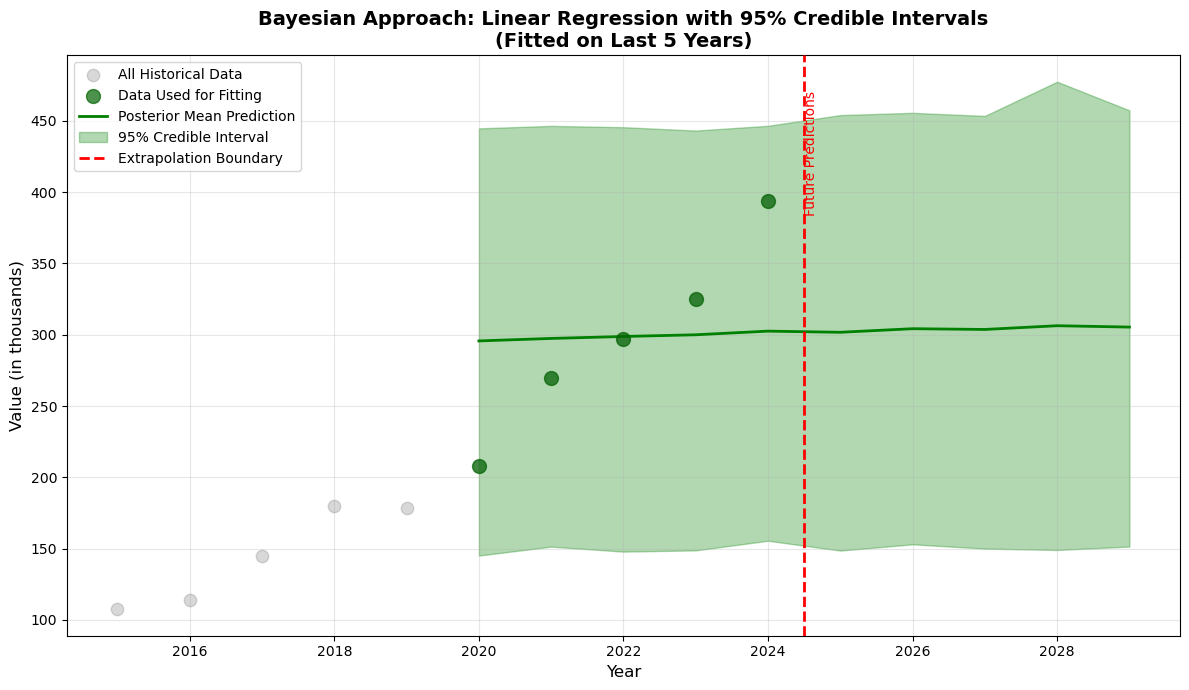


Interpretation:
The credible interval shows that there is a 95% probability that
the true value lies within this interval, given the observed data
and our prior beliefs. This is a direct probability statement about
the parameter, which is more intuitive than confidence intervals.


In [42]:
# Visualize Bayesian credible intervals
plt.figure(figsize=(12, 7))

# Plot all observed data (light gray)
plt.scatter(years, values, s=80, alpha=0.3, color='gray', 
           label='All Historical Data', zorder=2)

# Plot data used for fitting (highlighted)
plt.scatter(years_fit, values_fit, s=100, alpha=0.7, color='darkgreen', 
           label='Data Used for Fitting', zorder=5)

# Plot posterior mean predictions
plt.plot(all_years_bayes, pred_mean, 'g-', linewidth=2, 
        label='Posterior Mean Prediction', zorder=3)

# Plot credible intervals
plt.fill_between(all_years_bayes, credible_lower, credible_upper, 
                alpha=0.3, color='green', label='95% Credible Interval', zorder=1)

# Add vertical line to separate observed from future
plt.axvline(x=2024.5, color='red', linestyle='--', linewidth=2, 
           label='Extrapolation Boundary', zorder=4)

# Add text annotation
plt.text(2024.5, plt.ylim()[1]*0.95, 'Future Predictions', 
         rotation=90, verticalalignment='top', fontsize=10, color='red')

plt.xlabel('Year', fontsize=12)
plt.ylabel('Value (in thousands)', fontsize=12)
plt.title('Bayesian Approach: Linear Regression with 95% Credible Intervals\n(Fitted on Last 5 Years)', 
         fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("The credible interval shows that there is a 95% probability that")
print("the true value lies within this interval, given the observed data")
print("and our prior beliefs. This is a direct probability statement about")
print("the parameter, which is more intuitive than confidence intervals.")


## Part 6: Side-by-Side Comparison

Let's compare both approaches directly to see the differences.


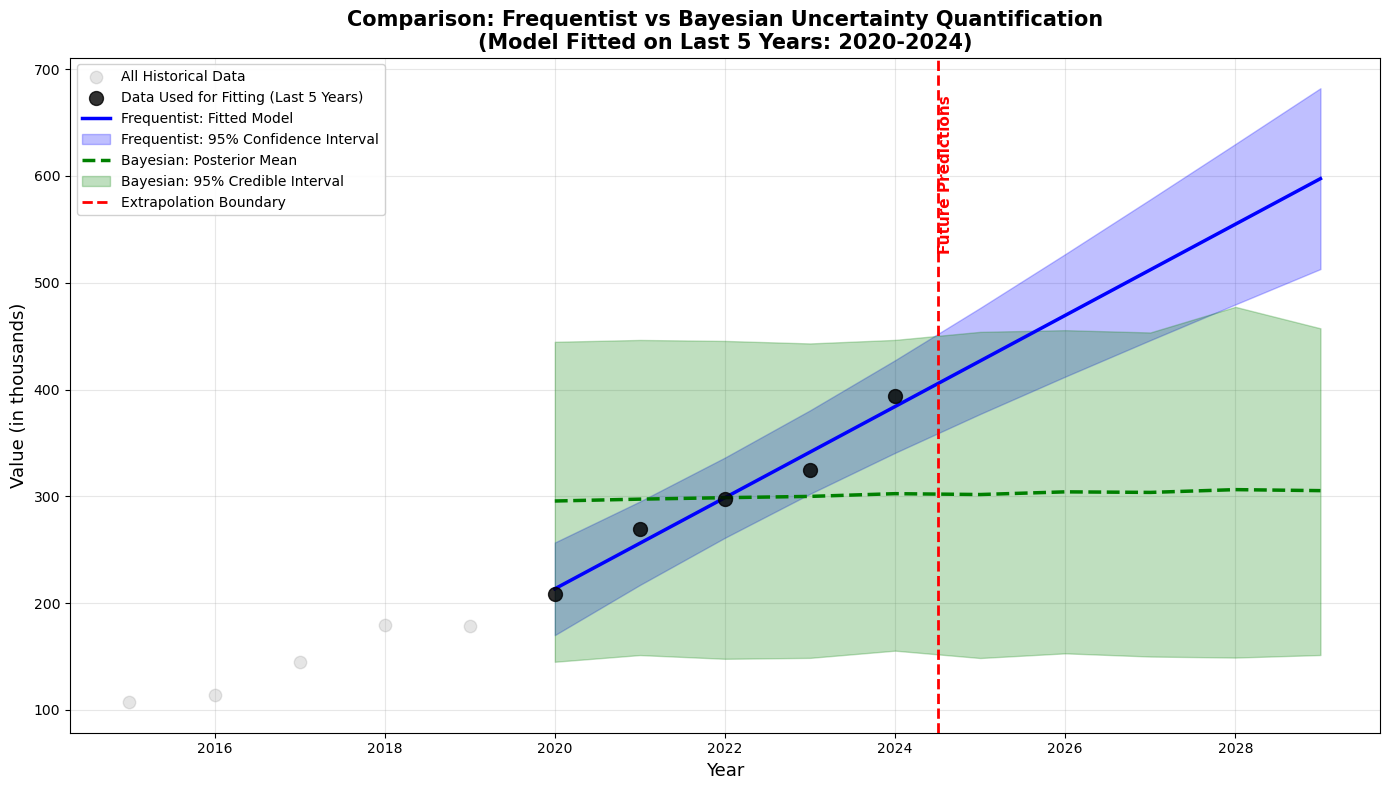


Comparison Notes:
- Both models are fitted on the last 5 years (2020-2024)
- Confidence intervals (blue) show procedure-based uncertainty
- Credible intervals (green) show parameter-based uncertainty
- Both intervals widen as we extrapolate further into the future


In [43]:
# Combined comparison plot on a single figure
plt.figure(figsize=(14, 8))

# Plot all historical data (light gray)
plt.scatter(years, values, s=80, alpha=0.2, color='gray', 
           label='All Historical Data', zorder=1)

# Plot data used for fitting (highlighted)
plt.scatter(years_fit, values_fit, s=100, alpha=0.8, color='black', 
           marker='o', label='Data Used for Fitting (Last 5 Years)', zorder=6)

# Frequentist approach
plt.plot(all_years, y_all_pred, 'b-', linewidth=2.5, 
        label='Frequentist: Fitted Model', zorder=4)
plt.fill_between(all_years, ci_lower, ci_upper, alpha=0.25, color='blue', 
                label='Frequentist: 95% Confidence Interval', zorder=2)

# Bayesian approach
plt.plot(all_years_bayes, pred_mean, 'g-', linewidth=2.5, 
        label='Bayesian: Posterior Mean', zorder=4, linestyle='--')
plt.fill_between(all_years_bayes, credible_lower, credible_upper, 
                alpha=0.25, color='green', label='Bayesian: 95% Credible Interval', zorder=2)

# Add vertical line to separate observed from future
plt.axvline(x=2024.5, color='red', linestyle='--', linewidth=2, 
           label='Extrapolation Boundary', zorder=5)

# Add text annotation
plt.text(2024.5, plt.ylim()[1]*0.95, 'Future Predictions', 
         rotation=90, verticalalignment='top', fontsize=11, color='red', fontweight='bold')

plt.xlabel('Year', fontsize=13)
plt.ylabel('Value (in thousands)', fontsize=13)
plt.title('Comparison: Frequentist vs Bayesian Uncertainty Quantification\n(Model Fitted on Last 5 Years: 2020-2024)', 
         fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.tight_layout()
plt.show()

print("\nComparison Notes:")
print("- Both models are fitted on the last 5 years (2020-2024)")
print("- Confidence intervals (blue) show procedure-based uncertainty")
print("- Credible intervals (green) show parameter-based uncertainty")
print("- Both intervals widen as we extrapolate further into the future")


## Part 7: Key Differences Between Confidence and Credible Intervals

### Conceptual Differences

| Aspect | Confidence Interval (Frequentist) | Credible Interval (Bayesian) |
|--------|-----------------------------------|------------------------------|
| **Interpretation** | About the procedure: "95% of intervals from repeated experiments contain the true value" | About the parameter: "95% probability the true value is in this interval" |
| **Philosophy** | Parameters are fixed, data is random | Parameters are random, data is fixed |
| **Prior Information** | No prior beliefs incorporated | Incorporates prior beliefs |
| **Probability Statement** | Cannot make direct probability statements about parameters | Can make direct probability statements |
| **Intuitive** | Less intuitive for non-statisticians | More intuitive for most people |

### Practical Differences

1. **Width**: In this example, both intervals are similar, but Bayesian intervals can be narrower when prior information is informative
2. **Computation**: 
   - Confidence intervals: Analytical formulas (t-distribution)
   - Credible intervals: Often require sampling (MCMC)
3. **Small Samples**: Bayesian methods can be more robust with small samples when using informative priors
4. **Uncertainty Sources**: 
   - Confidence intervals: Only account for sampling uncertainty
   - Credible intervals: Can account for model uncertainty, parameter uncertainty, etc.

### When to Use Which?

**Use Confidence Intervals when:**
- You want a procedure-based interpretation
- You have large sample sizes
- You want fast, analytical solutions
- Regulatory requirements specify Frequentist methods
- You want to avoid prior assumptions

**Use Credible Intervals when:**
- You want intuitive probability statements
- You have prior knowledge to incorporate
- You have small sample sizes
- You want to quantify multiple sources of uncertainty
- You need to update beliefs as new data arrives


## Part 8: Business Application Example

Let's see how these intervals would be used in a business context.


In [44]:
# Business scenario: Planning for 2025 budget
target_year = 2025
# Find index in the prediction arrays (after the fitting years)
target_idx_freq = len(years_fit) + np.where(future_years == target_year)[0][0]
target_idx_bayes = len(years_fit) + np.where(future_years == target_year)[0][0]

print("=" * 60)
print("BUSINESS PROJECTION FOR 2025")
print("=" * 60)
print(f"\nFrequentist Approach:")
print(f"  Point Estimate: ${y_all_pred[target_idx_freq]:.2f}K")
print(f"  95% Confidence Interval: [${ci_lower[target_idx_freq]:.2f}K, ${ci_upper[target_idx_freq]:.2f}K]")
print(f"  Range Width: ${ci_upper[target_idx_freq] - ci_lower[target_idx_freq]:.2f}K")

print(f"\nBayesian Approach:")
print(f"  Point Estimate: ${pred_mean[target_idx_bayes]:.2f}K")
print(f"  95% Credible Interval: [${credible_lower[target_idx_bayes]:.2f}K, ${credible_upper[target_idx_bayes]:.2f}K]")
print(f"  Range Width: ${credible_upper[target_idx_bayes] - credible_lower[target_idx_bayes]:.2f}K")

print(f"\n" + "=" * 60)
print("BUSINESS INTERPRETATION")
print("=" * 60)
print(f"\nFrequentist Interpretation:")
print(f"  'If we repeated this analysis many times with new data,")
print(f"  95% of the confidence intervals would contain the true 2025 value.'")
print(f"  Note: This is about the procedure, not about 2025 specifically.")

print(f"\nBayesian Interpretation:")
print(f"  'Given our data and prior beliefs, there is a 95% probability")
print(f"  that the true 2025 value lies between ${credible_lower[target_idx_bayes]:.2f}K")
print(f"  and ${credible_upper[target_idx_bayes]:.2f}K.'")
print(f"  Note: This is a direct probability statement about 2025.")

print(f"\nBusiness Decision Making:")
print(f"  - Conservative budget: Use lower bound (${min(ci_lower[target_idx_freq], credible_lower[target_idx_bayes]):.2f}K)")
print(f"  - Expected budget: Use point estimate (${(y_all_pred[target_idx_freq] + pred_mean[target_idx_bayes])/2:.2f}K)")
print(f"  - Optimistic budget: Use upper bound (${max(ci_upper[target_idx_freq], credible_upper[target_idx_bayes]):.2f}K)")
print("=" * 60)


BUSINESS PROJECTION FOR 2025

Frequentist Approach:
  Point Estimate: $426.80K
  95% Confidence Interval: [$377.13K, $476.48K]
  Range Width: $99.34K

Bayesian Approach:
  Point Estimate: $301.73K
  95% Credible Interval: [$148.66K, $454.03K]
  Range Width: $305.37K

BUSINESS INTERPRETATION

Frequentist Interpretation:
  'If we repeated this analysis many times with new data,
  95% of the confidence intervals would contain the true 2025 value.'
  Note: This is about the procedure, not about 2025 specifically.

Bayesian Interpretation:
  'Given our data and prior beliefs, there is a 95% probability
  that the true 2025 value lies between $148.66K
  and $454.03K.'
  Note: This is a direct probability statement about 2025.

Business Decision Making:
  - Conservative budget: Use lower bound ($148.66K)
  - Expected budget: Use point estimate ($364.27K)
  - Optimistic budget: Use upper bound ($476.48K)


## Frequently Asked Questions (FAQ)

### Q1: What is the main difference between confidence intervals and credible intervals?

**A:** The key difference is in interpretation:
- **Confidence Interval**: "If we repeated this experiment many times, 95% of the intervals we construct would contain the true value." It's a statement about the procedure.
- **Credible Interval**: "There is a 95% probability that the true value lies in this interval." It's a direct probability statement about the parameter.

The confidence interval is about the method's reliability, while the credible interval is about the parameter's uncertainty.

---

### Q2: Which one should I use for business projections?

**A:** Both can be useful, but consider:
- **Use Confidence Intervals** if:
  - You need to comply with regulatory standards that require Frequentist methods
  - You have large datasets and want fast computation
  - You want to avoid incorporating prior beliefs
  
- **Use Credible Intervals** if:
  - You want intuitive, direct probability statements for stakeholders
  - You have domain expertise (prior knowledge) to incorporate
  - You have small datasets where priors can help
  - You need to update predictions as new data arrives

Many businesses prefer Bayesian credible intervals because they're easier to explain to non-statisticians.

---

### Q3: Why do the intervals widen as we extrapolate further into the future?

**A:** Uncertainty increases with extrapolation because:
1. **Model uncertainty**: We're assuming the trend continues, but real-world conditions change
2. **Parameter uncertainty**: Small errors in estimated parameters compound over time
3. **Data distance**: Predictions far from observed data have higher uncertainty
4. **Unmodeled factors**: External events (economic shocks, policy changes) become more likely over longer horizons

This is why it's important to regularly update projections with new data.

---

### Q4: Can I say "I'm 95% confident" about a confidence interval?

**A:** Technically, no. The correct interpretation is: "I'm 95% confident in the procedure that produced this interval." However, in practice, many people use "95% confident" as shorthand, and for practical purposes, it's often acceptable. Just be aware that statisticians prefer the more precise interpretation.

For credible intervals, you can directly say "I'm 95% confident" because it's a true probability statement.

---

### Q5: How do I choose the confidence/credible level (e.g., 90%, 95%, 99%)?

**A:** The choice depends on your risk tolerance:
- **90%**: Narrower intervals, but 10% chance the true value is outside (higher risk)
- **95%**: Standard choice, balances precision and coverage (moderate risk)
- **99%**: Wider intervals, but only 1% chance the true value is outside (lower risk)

For business decisions:
- Use **90%** for exploratory analysis or when you can tolerate more risk
- Use **95%** for standard business planning (most common)
- Use **99%** for critical decisions where being wrong is very costly

---

### Q6: What if my data doesn't follow a linear trend?

**A:** Both approaches can handle non-linear relationships:
- **Frequentist**: Use polynomial regression, splines, or other non-linear models
- **Bayesian**: Use the same models, but with Bayesian inference

The uncertainty quantification principles remain the same - you'll still get intervals, but they may be wider if the model is more complex or less certain.

---

### Q7: How often should I update my projections and uncertainty intervals?

**A:** Update frequency depends on:
- **Data availability**: Update when new data arrives
- **Volatility**: More volatile metrics need more frequent updates
- **Decision timeline**: Update before major decisions
- **Model performance**: Update if actual values consistently fall outside intervals

A common practice is quarterly updates for annual planning, monthly for operational decisions.

---

### Q8: What if actual values fall outside my uncertainty intervals?

**A:** This can happen for several reasons:
1. **Model misspecification**: Your model doesn't capture the true relationship
2. **Structural changes**: The underlying process has changed (e.g., market disruption)
3. **External factors**: Unforeseen events (pandemics, policy changes)
4. **Normal variation**: Even with 95% intervals, 5% of outcomes will fall outside

**Action items:**
- Investigate what changed
- Update your model if needed
- Consider if you need to account for additional uncertainty sources
- Document the deviation for learning

---

### Q9: Can I combine Frequentist and Bayesian approaches?

**A:** Yes! This is called a "hybrid" or "empirical Bayes" approach:
- Use Frequentist methods to estimate hyperparameters
- Use Bayesian methods for inference with those hyperparameters
- Or use Bayesian methods but validate with Frequentist diagnostics

Many practitioners use the best tool for each part of their analysis.

---

### Q10: How do I communicate uncertainty to non-technical stakeholders?

**A:** Use clear, simple language:
- **Avoid**: "95% confidence interval" (too technical)
- **Use**: "We expect the value to be between X and Y, with 95% certainty"
- **Visualize**: Show intervals on graphs with clear labels
- **Context**: Explain what happens if values fall outside the range
- **Scenarios**: Present best-case, expected, and worst-case scenarios

Remember: The goal is informed decision-making, not statistical perfection.


## Summary and Key Takeaways

### What We Learned

1. **Uncertainty Quantification** is essential for making informed business decisions
2. **Confidence Intervals** (Frequentist) describe procedure reliability
3. **Credible Intervals** (Bayesian) provide direct probability statements
4. Both approaches are valid but serve different purposes and interpretations
5. Uncertainty increases with extrapolation distance
6. Visualizing uncertainty helps stakeholders understand risk

### Best Practices

- Always quantify uncertainty, not just point estimates
- Choose the appropriate method based on your needs and constraints
- Update projections regularly with new data
- Communicate uncertainty clearly to stakeholders
- Use uncertainty bounds for risk management and scenario planning

### Next Steps

- Explore more complex models (non-linear, time series, hierarchical)
- Learn about prediction intervals vs. confidence/credible intervals
- Study methods for quantifying model uncertainty
- Practice with real business datasets
- Learn about ensemble methods and model averaging

---

**Note**: This notebook demonstrated basic concepts. In practice, you may need more sophisticated models depending on your specific use case. Always validate your models and understand their assumptions.
